In [1]:
# !pip install PyPDF2
from PyPDF2 import PdfFileReader
import re
import pandas as pd

In [2]:
def extract_information(pdf_path):
    pdf_data = ""
    with open(pdf_path, 'rb') as f:
        pdf = PdfFileReader(f)
        information = pdf.getDocumentInfo()
        number_of_pages = pdf.getNumPages()
        ifrs_data = []
        merged_content = ""
        start_flag = 0
        pattern = "(.*?)\s([1-9][0-9][0-9]|[1-9][0-9]|[0-9]\s)"
        for page_n in range(number_of_pages):
            page = pdf.pages[page_n]
            data = (page.extract_text() + "\n\n").lstrip()
            content_start = "OBJECTIVE"
            content_end = "APPENDICES"
            content_head_start = "INTERNATIONAL FINANCIAL REPORTING STANDARD 15 REVENUE FROM CONTRACTS WITH CUSTOMERS".replace(" ", "(\s|\n)")
            content_head_end = "Appendix A"
            if data.startswith("CONTENT"):
                heads = data[data.index(content_start): data.index(content_end)].replace("\n", " ").replace("  ", " ")
                match = re.findall(pattern, heads)
                prev_para = 1
                for head, para_num in match:
                    para_num = int(para_num.strip())
                    head = head.strip()
                    if head.isupper():
                        head = head.capitalize()
                    ifrs_data.append({
                        "Paragraph": para_num,
                        "Tag": head
                    })
            if re.match(content_head_end, data, re.I):
                start_flag = 0
                merged_content += "\n" + content_head_end
            elif re.match(content_head_start, data, re.I):
                start_flag = 1
                merged_content = ""
            if start_flag:
                ending_dirt_text_cp_pattern = "(A\d+ © IFRS Foundation|© IFRS Foundation A\d+)"
                ending_dirt_text_num_pattern = "(\d+\n)*(\d+IFRS 15\s\n)$"
                if re.search(ending_dirt_text_cp_pattern, data, re.I):
                    data = re.sub(ending_dirt_text_cp_pattern, "", data)
                if re.search(ending_dirt_text_num_pattern, data, re.I):
                    data = re.sub(ending_dirt_text_num_pattern, "", data)
                merged_content += data
        merged_content = merged_content.replace("\n", "$$$")
        for i in range(len(ifrs_data)):
            if i == len(ifrs_data) - 1:
                match_paragraph_pattern =  "\$\$\$" + ifrs_data[i]["Tag"] + "\$\$\$" + "(.*?)" + "\$\$\$" + content_head_end + "\$\$\$"
                match = re.search(match_paragraph_pattern, merged_content)
            else:
                match_paragraph_pattern = "\$\$\$" + ifrs_data[i]["Tag"] + "\$\$\$" + "(.*?)" + "\$\$\$" + ifrs_data[i+1]["Tag"] + "\$\$\$"
                match = re.search(match_paragraph_pattern, merged_content)
            if match and match.group(1).strip():
                ifrs_data[i]["data"] = match.group(1).replace("$$$", " ").strip().replace("  ", " ").replace(" .", ".").replace(" -", " - ")

        # for ifrs in ifrs_data:
        #     print("-" if "data" in ifrs else str(ifrs['Paragraph']) + "-" + ifrs['Tag'] + "-Missing!")
#        Para missing data: 91, 95, 113, 123, 127
    return ifrs_data

In [3]:
file = "..//data//IFRS15.pdf"
ifrs_data = extract_information(file)

In [4]:
ifrs_data = [ifrs for ifrs in ifrs_data if "data" in ifrs]

In [5]:
# !pip install git+https://github.com/pmbaumgartner/setfit -q

In [6]:
df = pd.DataFrame(ifrs_data, columns=['Tag', 'data'])

In [7]:
df

,Tag,data
0,Objective,The objective of this Standard is to establish...
1,Meeting the objective,"To meet the objective in paragraph 1, the core..."
2,Scope,An entity shall apply this Standard to all con...
3,Identifying the contract,An entity shall account for a contract with a ...
4,Combination of contracts,An entity shall combine two or more contracts ...
5,Contract modifications,A contract modification is a change in the sco...
6,Identifying performance obligations,"At contract inception, an entity shall assess ..."
7,Satisfaction of performance obligations,An entity shall recognise revenue when (or as)...
8,Measurement,When (or as) a performance obligation is satis...
9,Changes in the transaction price,"After contract inception, the transaction pric..."


In [8]:
from setfit import SetFitClassifier

In [9]:
clf = SetFitClassifier("paraphrase-MiniLM-L3-v2")

In [10]:
docs = df['data'].to_list()
labels = df['Tag'].to_list()

In [11]:
clf.fit(docs, labels) 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
test_data = [
                {"Tag": "Recognition", "data": "the customer can benefit from the good or service either on its own or together with other resources that are readily available to the customer (ie the good or service is capable of being distinct);"}, 
                {"Tag": "Objective", "data": """The objective of this Standard is to establish the principles that an entity shall apply to report useful information to users of financial statements about the nature, amount, timing and uncertainty of revenue and cash flows arising from a contract with a customer."""}
            ]

In [13]:
df_test = pd.DataFrame(test_data, columns=['Tag', 'data'])

In [14]:
df_test['predicted'] = clf.predict(df_test['data'].to_list())

In [15]:
df_test

,Tag,data,predicted
0,Recognition,the customer can benefit from the good or serv...,Identifying performance obligations
1,Objective,The objective of this Standard is to establish...,Objective


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [19]:
cm = confusion_matrix(df_test['Tag'], df_test['predicted'])
cm

array([[0, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

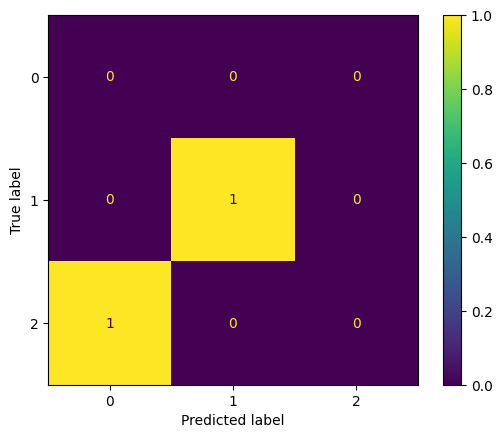

In [21]:
disp.plot()